In [1]:
from PIL import Image
import requests
from transformers import IdeficsForVisionText2Text, AutoProcessor
import torch
import json
import numpy as np

import os

from baukit import TraceDict
device = "cuda" if torch.cuda.is_available() else "cpu"

[2023-12-12 23:45:23,292] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
checkpoint = "HuggingFaceM4/idefics-9b-instruct"
model = IdeficsForVisionText2Text.from_pretrained(checkpoint,device_map="auto")
processor = AutoProcessor.from_pretrained(checkpoint)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
for k,v in model.named_modules():
    print(k)


model
model.embed_tokens
model.embed_tokens.additional_embedding
model.vision_model
model.vision_model.embeddings
model.vision_model.embeddings.patch_embedding
model.vision_model.embeddings.position_embedding
model.vision_model.pre_layrnorm
model.vision_model.encoder
model.vision_model.encoder.layers
model.vision_model.encoder.layers.0
model.vision_model.encoder.layers.0.self_attn
model.vision_model.encoder.layers.0.self_attn.k_proj
model.vision_model.encoder.layers.0.self_attn.v_proj
model.vision_model.encoder.layers.0.self_attn.q_proj
model.vision_model.encoder.layers.0.self_attn.out_proj
model.vision_model.encoder.layers.0.layer_norm1
model.vision_model.encoder.layers.0.mlp
model.vision_model.encoder.layers.0.mlp.activation_fn
model.vision_model.encoder.layers.0.mlp.fc1
model.vision_model.encoder.layers.0.mlp.fc2
model.vision_model.encoder.layers.0.layer_norm2
model.vision_model.encoder.layers.1
model.vision_model.encoder.layers.1.self_attn
model.vision_model.encoder.layers.1.self_

In [4]:
# device = torch.device('cuda:2')

In [5]:
image_folder = f'/home/ubuntu/VG_Relation/images'
question_file = '/home/ubuntu/VG_Relation/vgr_val_QCM_noyes.json'
questions = json.load(open(question_file, "r"))

In [6]:
random_idx = np.random.choice(len(questions))
q = questions[random_idx]['conversations'][0]['value'].split('<image>')[0].rstrip().replace("\n", " ")
# .split('Answer ')[0].rstrip()
# caption = questions[random_idx]['conversations'][0]['value'].split('<image>')[0].rstrip().replace("\n", " ").split('. ')[-1].strip()
# prompt = q + " " + caption

In [7]:
q

'Does this caption correctly describes the image? Answer with a no or yes. the doll is to the right of the stuffed animal'

In [8]:
image = Image.open(questions[random_idx]['image'])

In [9]:
# We feed to the model an arbitrary sequence of text strings and images. Images can be either URLs or PIL Images.
prompts = [
    [
        image,
        f"User: {q}",
        "<end_of_utterance>",
        "\nAssistant:",
    ],
]


In [10]:
prompts

[[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
  'User: Does this caption correctly describes the image? Answer with a no or yes. the doll is to the right of the stuffed animal',
  '<end_of_utterance>',
  '\nAssistant:']]

In [11]:
inputs = processor(prompts, add_end_of_utterance_token=False, return_tensors="pt").to(device)

In [12]:
# Generation args
exit_condition = processor.tokenizer("<end_of_utterance>", add_special_tokens=False).input_ids
bad_words_ids = processor.tokenizer(["<image>", "<fake_token_around_image>"], add_special_tokens=False).input_ids

generated_ids = model.generate(**inputs, eos_token_id=exit_condition, bad_words_ids=bad_words_ids, max_length=100)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text

['User: Does this caption correctly describes the image? Answer with a no or yes. the doll is to the right of the stuffed animal \nAssistant: yes']

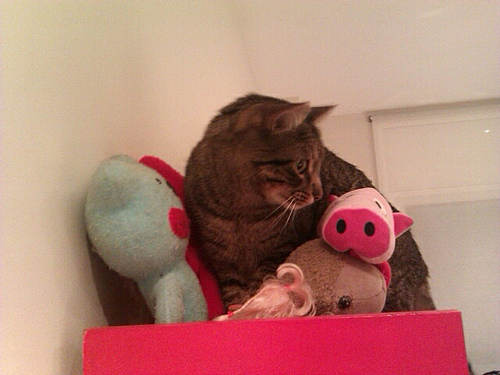

In [13]:
image

In [14]:
model.config

IdeficsConfig {
  "_name_or_path": "HuggingFaceM4/idefics-9b-instruct",
  "additional_vocab_size": 3,
  "alpha_initializer": "zeros",
  "alpha_type": "float",
  "alphas_initializer_range": 0.0,
  "architectures": [
    "IdeficsForVisionText2Text"
  ],
  "bos_token_id": 1,
  "cross_layer_activation_function": "swiglu",
  "cross_layer_interval": 4,
  "dropout": 0.0,
  "eos_token_id": 2,
  "freeze_lm_head": false,
  "freeze_text_layers": false,
  "freeze_text_module_exceptions": [],
  "freeze_vision_layers": false,
  "freeze_vision_module_exceptions": [],
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 2048,
  "max_sequence_length": 2048,
  "model_type": "idefics",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "pad_token_id": 0,
  "perceiver_config": {
    "model_type": "idefics",
    "qk_layer_norms_perceiver": true
  },
  "qk_layer_norms": true,
  "rms_norm_eps": 1e-06,
  "tie_word_embeddi

In [15]:
HEADS = [f"model.layers.{i}.self_attn.o_proj" for i in range(model.config.num_hidden_layers)]
MLPS = [f"model.layers.{i}.mlp" for i in range(model.config.num_hidden_layers)]

In [16]:
def get_single_activation(model,HEADS, MLPS,inputs):
    with torch.inference_mode():
        with TraceDict(model, HEADS+MLPS, retain_input=True) as ret:
            generated_ids = model(**inputs,output_hidden_states = True)
    print(generated_ids.keys())
    # print(generated_ids['language_model_outputs'].keys())
    layer_wise_activations = generated_ids.hidden_states
    layer_wise_activations = torch.stack(layer_wise_activations, dim = 0).squeeze()
    layer_wise_activations = layer_wise_activations.detach().cpu().numpy()

    head_wise_activations = [ret[head].input.squeeze().detach().cpu() for head in HEADS]
    head_wise_activations = torch.stack(head_wise_activations, dim = 0).squeeze().numpy()
    
    return layer_wise_activations, head_wise_activations

In [17]:
layer_wise, head_wise = get_single_activation(model, HEADS, MLPS, inputs)

odict_keys(['logits', 'past_key_values', 'hidden_states', 'image_hidden_states'])


In [ ]:
layer_wise.shape

In [ ]:
head_wise.shape

In [ ]:
generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
generated_text

In [ ]:
generated_text

In [ ]:
q

In [ ]:
image